# Local Lengthscale GP with PyMC

Author: [Zeel B Patel](https://patel-zeel.github.io/), [Nipun Batra](https://nipunbatra.github.io/)

In this chapter, we explore a non-stationary GP discussed by {cite}`LLSGP` with PyMC.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pymc3 as pm
from sklearn.cluster import KMeans
import warnings
from multiprocessing import Pool
warnings.filterwarnings('ignore')

rc('font', size=16)

Let us define both stationary and non-statioanry RBF kernels,

In [2]:
### Stationary GP
def kernel(a, b, lenghtscale, std):
    """
    Borrowed from Nando De Freita's lecture code
    https://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py
    """
    sqdist = np.square(a - b.T)
    return std**2*np.exp(-.5 * (1/lenghtscale) * sqdist)

### LLS GP
def global_kernel(x1, x2, l1, l2, std):
    sqdist = np.square(x1 - x2.T)
    l1l2meansqr = (np.square(l1)[:, np.newaxis, :] + np.square(l2)[np.newaxis, :, :]).squeeze()/2
#     print(sqdist.shape, l1l2meansqr.shape)
    return std**2 * pm.math.matrix_dot(np.sqrt(l1),np.sqrt(l2.T)) * (1/np.sqrt(l1l2meansqr)) * np.exp(-sqdist/l1l2meansqr)

def local_kernel(x1, x2, lengthscale):
    """
    Borrowed from Nando De Freita's lecture code
    https://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py
    """
    sqdist = np.square(x1 - x2.T)
    return np.exp(-.5 * (1/lengthscale) * sqdist)

We will test the efficacy of these models on a step function data.

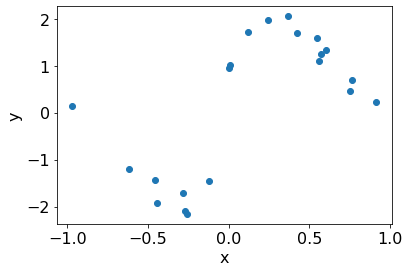

In [3]:
n_train = 21
np.random.seed(1234)

# Generate data
def f(X):  # target function
    return np.sin(5*X) + np.sign(X)

X = np.random.uniform(-1, 1, (n_train, 1)).reshape(-1,1)  # data
Y = f(X)[:, 0] + np.random.normal(0,0.2,n_train)
plt.scatter(X, Y);
plt.xlabel('x');
plt.ylabel('y');

### Stationary GP model

In [4]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    # Variance
    kernel_std = pm.Lognormal("kernel_std", 0, 0.1)
    # Length scale
    kernel_ls = pm.Lognormal("kernel_ls", 0, 1)
    noise_sigma = pm.Lognormal("noise_sigma", 0, 1)
    K = kernel(X, X, kernel_ls, kernel_std) 
    K += np.eye(X.shape[0]) * np.power(noise_sigma, 2)
    
    y = pm.MvNormal("y", mu = 0, cov = K, observed = Y.squeeze())

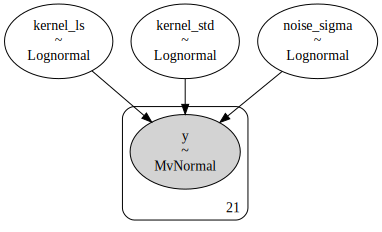

In [5]:
pm.model_to_graphviz(basic_model.model)

Let us find MAP estimate of paramaters.

In [6]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'kernel_std_log__': array(0.02655438),
 'kernel_ls_log__': array(-2.68569403),
 'noise_sigma_log__': array(-1.27853804),
 'kernel_std': array(1.02691009),
 'kernel_ls': array(0.06817386),
 'noise_sigma': array(0.27844408)}

Now, we will sample from the posterior.

In [7]:
with basic_model:
    # draw 2000 posterior samples per chain
    trace = pm.sample(2000,return_inferencedata=False,tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise_sigma, kernel_ls, kernel_std]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.


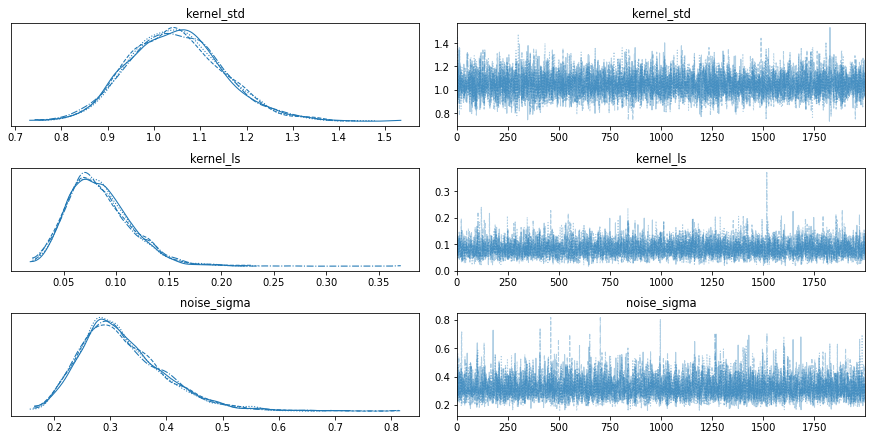

In [8]:
import arviz as az

az.plot_trace(trace);

Now, we will infer the $y$ values at new input locations.

In [9]:
test_x = np.linspace(-1.5, 1.5, 100).reshape(-1, 1)
train_x = X
train_y = Y

def post(train_x, train_y, test_x, kernel, kernel_ls, kernel_std, noise):
    N = len(train_x)
    K = kernel(train_x, train_x, kernel_ls, kernel_std)+noise**2*np.eye(len(train_x))
    N_star = len(test_x)
    K_star = kernel(train_x,  test_x, kernel_ls, kernel_std)
    K_star_star = kernel(test_x, test_x, kernel_ls, kernel_std)
    posterior_mu = K_star.T@np.linalg.inv(K)@(train_y)
    posterior_sigma = K_star_star - K_star.T@np.linalg.inv(K)@K_star
    
    # Instead of size = 1, we can also sample multiple times given a single length scale, kernel_std and noise
    return np.random.multivariate_normal(posterior_mu, posterior_sigma, size=1)

In [10]:
# Make predictions at new locations.
train_y = Y.squeeze()
n_samples = 500
preds = np.stack([post(train_x, train_y, test_x=test_x, kernel=kernel, kernel_ls=trace['kernel_ls'][b],
                             kernel_std=trace['kernel_std'][b],
                             noise=trace['noise_sigma'][b])
                  for b in range(n_samples)])

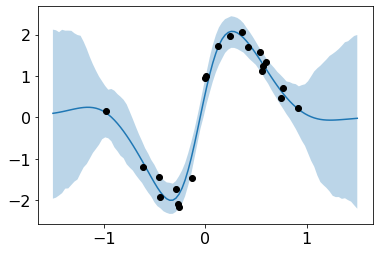

In [11]:
ci = 95
ci_lower = (100 - ci) / 2
ci_upper = (100 + ci) / 2
preds_mean = preds.reshape(n_samples, len(test_x)).mean(0)
preds_lower = np.percentile(preds, ci_lower, axis=0)
preds_upper = np.percentile(preds, ci_upper, axis=0)

plt.plot(test_x,preds.reshape(n_samples, len(test_x)).mean(axis=0))

plt.scatter(train_x, train_y, c='black', zorder=3, label='data')
plt.fill_between(test_x.flatten(), preds_upper.flatten(), preds_lower.flatten(), alpha=.3, label='95% CI');

### LLS GP

We will learn local lengthscales at 3 input locations choosen by KMeans clustering.

In [22]:
n_local = 3
lls_model = pm.Model()
param_X = KMeans(n_local, random_state=0).fit(X).cluster_centers_

with lls_model:
    
    ### Local GP
    # local lengthscale
    local_ls = pm.Lognormal("local_ls", 0, 1)
    param_ls = pm.Lognormal("param_ls", 0, 1, shape=(n_local, 1))
    local_K = local_kernel(param_X, param_X, local_ls)
    local_K_star = local_kernel(X, param_X, local_ls)
    
    ### global GP
    # global lengthscales
    global_ls = pm.math.exp(pm.math.matrix_dot(local_K_star, pm.math.matrix_inverse(local_K), pm.math.log(param_ls)))
    # global variance
    global_std = pm.Lognormal("global_std", 0, 1)
    # global noise
    global_noise_sigma = pm.Lognormal("global_noise_sigma", 0, 1)
    
    global_K = global_kernel(X, X, global_ls, global_ls, global_std)
    global_K += np.eye(X.shape[0])*global_noise_sigma**2
    
    y = pm.MvNormal("y", mu = 0, cov = global_K, observed = Y)

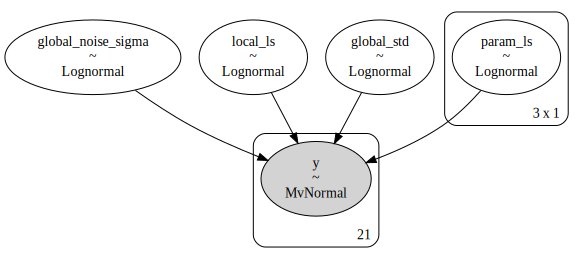

In [23]:
pm.model_to_graphviz(lls_model.model)

Let us find MAP estimate of paramaters.

In [24]:
NSmap_estimate = pm.find_MAP(model=lls_model)
NSmap_estimate

{'local_ls_log__': array(-0.88024402),
 'param_ls_log__': array([[-0.28197464],
        [-0.05336731],
        [-1.54950142]]),
 'global_std_log__': array(0.09507128),
 'global_noise_sigma_log__': array(-1.61986434),
 'local_ls': array(0.41468171),
 'param_ls': array([[0.75429281],
        [0.94803173],
        [0.21235382]]),
 'global_std': array(1.09973724),
 'global_noise_sigma': array(0.19792555)}

In [32]:
with lls_model:
    # draw 2000 posterior samples per chain
    trace = pm.sample(4000,return_inferencedata=False,tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_noise_sigma, global_std, param_ls, local_ls]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 43 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


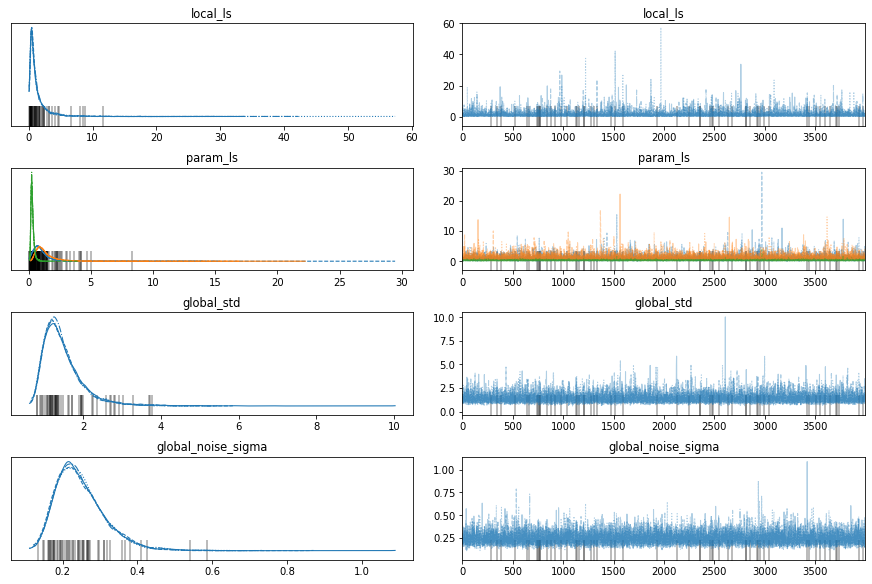

In [33]:
import arviz as az
with lls_model:
    az.plot_trace(trace);

Let us predict the values at new locations.

In [34]:
test_x = np.linspace(-1.5, 1.5, 100).reshape(-1, 1)
train_x = X
train_y = Y

def post(local_ls, param_ls, global_std, global_noise):
    N = len(train_x)
    param_K_inv = np.linalg.inv(local_kernel(param_X, param_X, local_ls))
    local_K = local_kernel(train_x, param_X, local_ls)
    global_ls = np.exp(local_K@param_K_inv@param_ls)
    local_K_star = local_kernel(test_x, param_X, local_ls)
    global_ls_star = np.exp(local_K_star@param_K_inv@param_ls)
    K = global_kernel(train_x, train_x, global_ls, global_ls, global_std)+np.eye(N)*global_noise**2
    K_inv = pm.math.matrix_inverse(K)
    K_star = global_kernel(train_x, test_x, global_ls, global_ls_star, global_std)
    posterior_mu = pm.math.matrix_dot(K_star.T,K_inv,train_y)
    
    return posterior_mu.eval()
    # Instead of size = 1, we can also sample multiple times given a single length scale, kernel_std and noise
    return np.random.multivariate_normal(posterior_mu.eval(), posterior_sigma.eval(), size=1)

In [35]:
# Make predictions at new locations.
n_samples = 100

preds = np.stack([post(local_ls=trace['local_ls'][b],
                       param_ls=trace['param_ls'][b],
                       global_std=trace['global_std'][b],
                      global_noise=trace['global_noise_sigma'][b])
                  for b in range(n_samples)])

Let us visualize predictive mean and variance.

In [36]:
ci = 95
ci_lower = (100 - ci) / 2
ci_upper = (100 + ci) / 2
preds_mean = preds.reshape(n_samples, len(test_x)).mean(0)
preds_lower = np.percentile(preds, ci_lower, axis=0)
preds_upper = np.percentile(preds, ci_upper, axis=0)

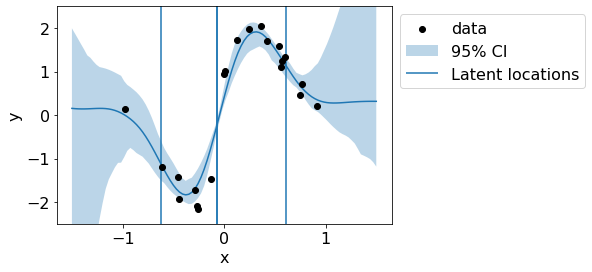

In [37]:
plt.plot(test_x,preds.reshape(n_samples, len(test_x)).mean(axis=0))

plt.scatter(train_x, train_y, c='black', zorder=3, label='data')
plt.fill_between(test_x.flatten(), preds_upper.flatten(), preds_lower.flatten(), alpha=.3, label='95% CI');
for x_loc in param_X:
    plt.vlines(x_loc, -3, 3);
plt.vlines(x_loc, -3, 3, label='Latent locations');
plt.legend(bbox_to_anchor=(1,1));
plt.ylim(-2.5,2.5);
plt.xlabel('x')
plt.ylabel('y');

Let us visualize the latent lengthscales.

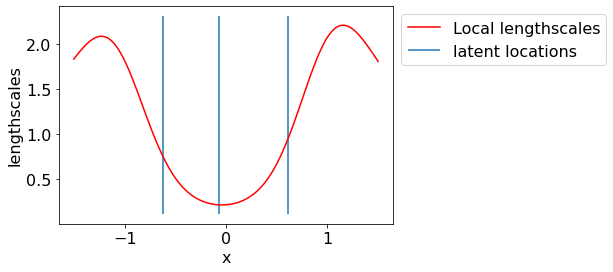

In [38]:
local_ls = NSmap_estimate['local_ls']
param_ls = NSmap_estimate['param_ls']
local_K = local_kernel(param_X, param_X, local_ls)
local_K_star = local_kernel(test_x, param_X, local_ls)

global_ls = pm.math.exp(pm.math.matrix_dot(local_K_star, pm.math.matrix_inverse(local_K), pm.math.log(param_ls)))
plt.plot(test_x, global_ls.eval(), label='Local lengthscales', color='r');
plt.vlines(param_X.squeeze(), *plt.ylim(), label='latent locations')
plt.xlabel('x')
plt.ylabel('lengthscales');
plt.legend(bbox_to_anchor=(1,1));

We see that lengthscales are low in the center region where the underlying function is having a sudden jump. Thus, LLS model is giving us sensible predictions.